In [1]:
%load_ext autoreload
%autoreload 2

import itertools

import awkward as ak
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

from python.analysis import Plots, shower_merging
from python.analysis.shower_merging import SetPlotStyle
SetPlotStyle()


def figure_dimensions(x, orientation : str = "horizontal"):
    nearest_square = int(np.ceil(x**0.5))

    if x < 4:
        dim = (1, x)
    elif (nearest_square - 1) * nearest_square >= x:
        dim = ((nearest_square - 1), nearest_square)
    else:
        dim = (nearest_square, nearest_square)
    
    if orientation == "vertical":
        dim = dim[::-1]
    return dim


def Hist2DComparison(x, y, x_range, y_range, x_labels = None, y_labels = None, titles = None, bins = 50, cmap = "plasma", func = None, orientation = "horizontal"):
    if x_labels is None: x_labels = [""]*len(x)
    if y_labels is None: y_labels = [""]*len(y)
    if titles is None: titles = [""] * len(x)

    dim = figure_dimensions(len(x), orientation)
    fig_size = (6.4 * dim[1], 4.8 * dim[0])
    ranges = [x_range, y_range]

    vmax = 0
    for xs, ys in zip(x, y):
        h, _, _ = np.histogram2d(xs, ys, bins, range = ranges)
        vmax = max(vmax, np.max(h))

    fig = plt.figure(figsize = fig_size)
    for i in range(len(x)):
        plt.subplot(*dim, i + 1)
        if func is None:
            _, _, _, im = plt.hist2d(x[i], y[i], bins, range = ranges, cmin = 1, vmin = 0, vmax = vmax, cmap = cmap)
        else:
            _, _, _, im = func(x = x[i], y = y[i], bins = bins, ranges = ranges, cmin = 1, vmin = 0, vmax = vmax, cmap = cmap)
        plt.xlabel(x_labels[i])
        plt.ylabel(y_labels[i])
        plt.title(titles[i])
    plt.tight_layout()
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.subplots_adjust(right=0.8)
    fig.colorbar(im, cax = cbar_ax)


In [3]:
save = False
file = "work/2023/Prod4a_1GeV_BeamSim_merging_analysis/shower_merging/new_tables/shower_pairs.hdf5"
data = {
    "unmerged" : pd.read_hdf(file, "/unmerged/reco/"),
    "merged"   : pd.read_hdf(file, "/merged/reco/"),
    "true"         : pd.read_hdf(file, "/true/")
}

[(array([ 4., 12., 24., 35., 37., 28., 23., 24., 17., 24., 21., 17., 13.,
          7.,  8., 10., 10.,  5.,  6.,  6.,  7.,  3.,  3.,  1.,  3.]),
  array([  4.91974341,  24.26271559,  43.60568777,  62.94865995,
          82.29163213, 101.63460431, 120.97757649, 140.32054867,
         159.66352085, 179.00649303, 198.34946521, 217.69243739,
         237.03540957, 256.37838175, 275.72135393, 295.0643261 ,
         314.40729828, 333.75027046, 353.09324264, 372.43621482,
         391.779187  , 411.12215918, 430.46513136, 449.80810354,
         469.15107572, 488.4940479 ])),
 (array([ 3., 11., 20., 32., 40., 24., 27., 23., 16., 24., 21., 17., 16.,
          8.,  8.,  9., 11.,  6.,  6.,  6.,  8.,  3.,  3.,  1.,  4.]),
  array([  4.91974309,  24.262718  ,  43.6056929 ,  62.94866781,
          82.29164272, 101.63461762, 120.97759253, 140.32056744,
         159.66354235, 179.00651725, 198.34949216, 217.69246707,
         237.03544197, 256.37841688, 275.72139179, 295.06436669,
         314.4073416

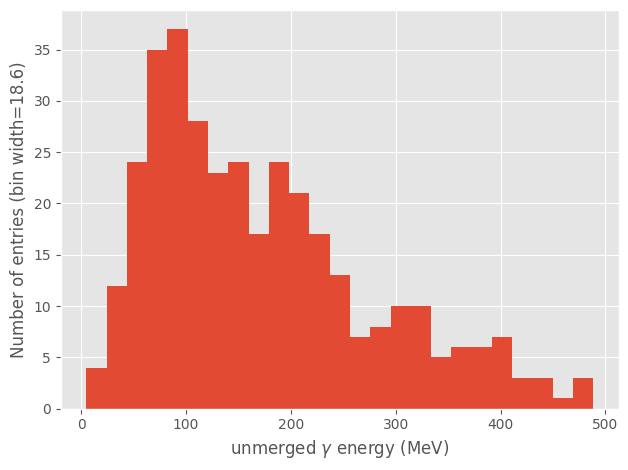

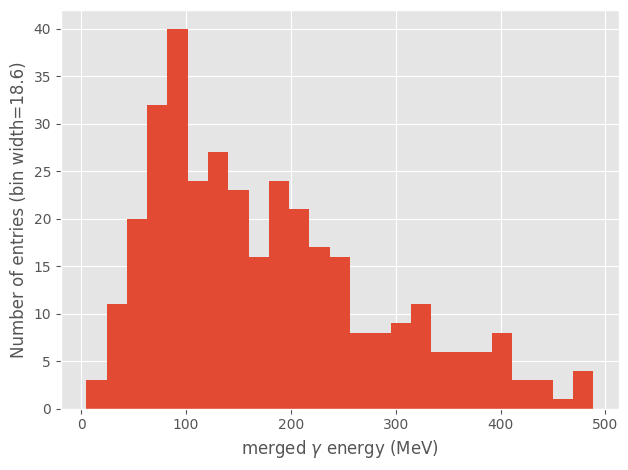

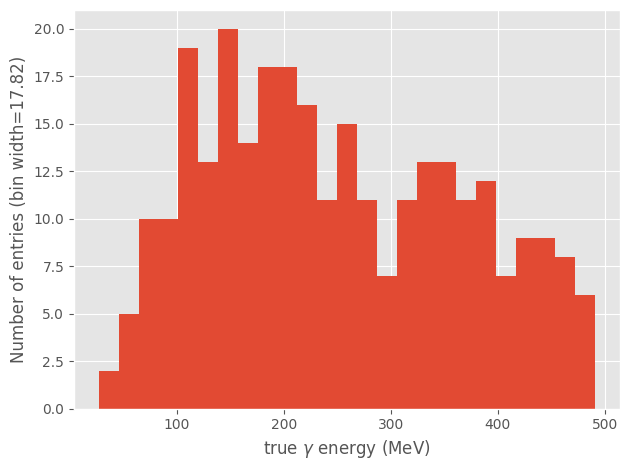

In [10]:
energy = {}
for d in data:
    energy[d] = np.concatenate([data[d].lead_energy, data[d].sub_energy])

[Plots.PlotHist(e[e <= 500], bins = 25, xlabel = k + " $\gamma$ energy (MeV)") for k, e in energy.items()]

/tmp/ipykernel_75305/2188524601.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, _, _, _ = np.linalg.lstsq(x_f[:, np.newaxis], y_f)


[0.59097102]
[0.60870753]
[0.74761137]


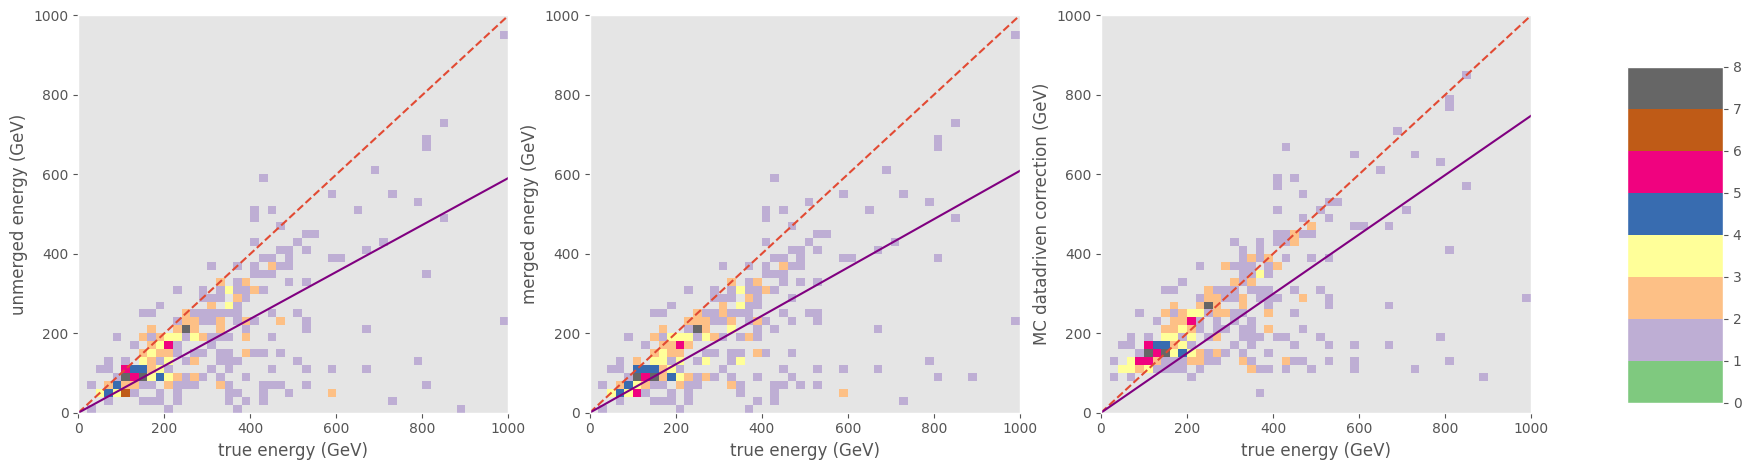

In [11]:
def EnergyCorrection(energy):
    correction = -0.1114 + (-0.9051 - -0.1114)/(1 + np.power((energy / 1000)/ 0.06237, 1.496))
    return energy / (1 + correction)


def ComparisonPlot(x, y, bins, ranges, cmin, vmin, vmax, cmap):
    x_m = (x > min(ranges[0])) & (x < max(ranges[0]))
    y_m = (y > min(ranges[1])) & (y < max(ranges[1]))
    mask = x_m & y_m
    x_f = x[mask]
    y_f = y[mask]
    m, _, _, _ = np.linalg.lstsq(x_f[:, np.newaxis], y_f)
    print(m)

    h = plt.hist2d(x, y, bins, range = ranges, cmin = cmin, vmin = vmin, vmax = vmax, cmap = cmap)
    x = np.linspace(0, 1000, 100)
    plt.plot(x, x, linestyle = "--")
    plt.plot(x, m * x, linestyle = "-", color = "purple")
    plt.xlim(ranges[0])
    plt.ylim(ranges[1])
    return h

x = [energy["true"]] * 3
y = [energy["unmerged"], energy["merged"], EnergyCorrection(energy["unmerged"])]
x_label = ["true energy (GeV)"] * 3
y_label = ["unmerged energy (GeV)", "merged energy (GeV)", "MC datadriven correction (GeV)"]

Hist2DComparison(x, y, (0, 1000), (0, 1000), x_label, y_label, bins = 50, cmap = "Accent", func = ComparisonPlot)
if save: Plots.Save("reco_vs_true")

In [12]:
def MergedEnergyCorrection(energy):
    return energy ** popt[0]

x = energy["true"]
y = energy["merged"]
x_range = [0, 1000]
y_range = [0, 1000]

x_mask = (x < max(x_range)) & (min(x_range) < x)
y_mask = (y < max(y_range)) & (min(y_range) < y)

x = x[x_mask & y_mask]
y = y[x_mask & y_mask]

popt, pcov = scipy.optimize.curve_fit(lambda x,m : x**m, y, x)

print(f"{popt=}")
print(f"{pcov=}")

m, _, _, _ = np.linalg.lstsq(x[:, np.newaxis], y)
print(m)

linear_correction = popt[0]

# ComparisonPlot(x, MergedEnergyCorrection(y), "true energy", "corrected merged")

energy["corrected_merged"] = MergedEnergyCorrection(energy["merged"])

popt=array([1.04222977])
pcov=array([[2.44855649e-05]])
[0.60870753]


/tmp/ipykernel_75305/3186628617.py:20: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, _, _, _ = np.linalg.lstsq(x[:, np.newaxis], y)


-79.80643161968267
-76.32362251607381
-13.242327063009668
-26.670459660634542


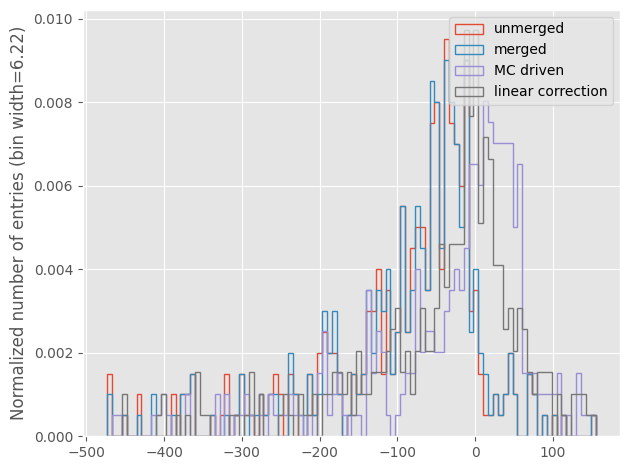

In [13]:
r = {
    "unmerged" : energy["unmerged"] - energy["true"],
    "merged"   : energy["merged"] - energy["true"],
    "MC driven" : EnergyCorrection(energy["unmerged"]) - energy["true"],
    "linear correction" : MergedEnergyCorrection(energy["merged"]) - energy["true"]
}
Plots.PlotHistComparison(list(r.values()), labels = list(r.keys()), xRange = [-500, 500])

for x in r:
    print(np.median(r[x]))

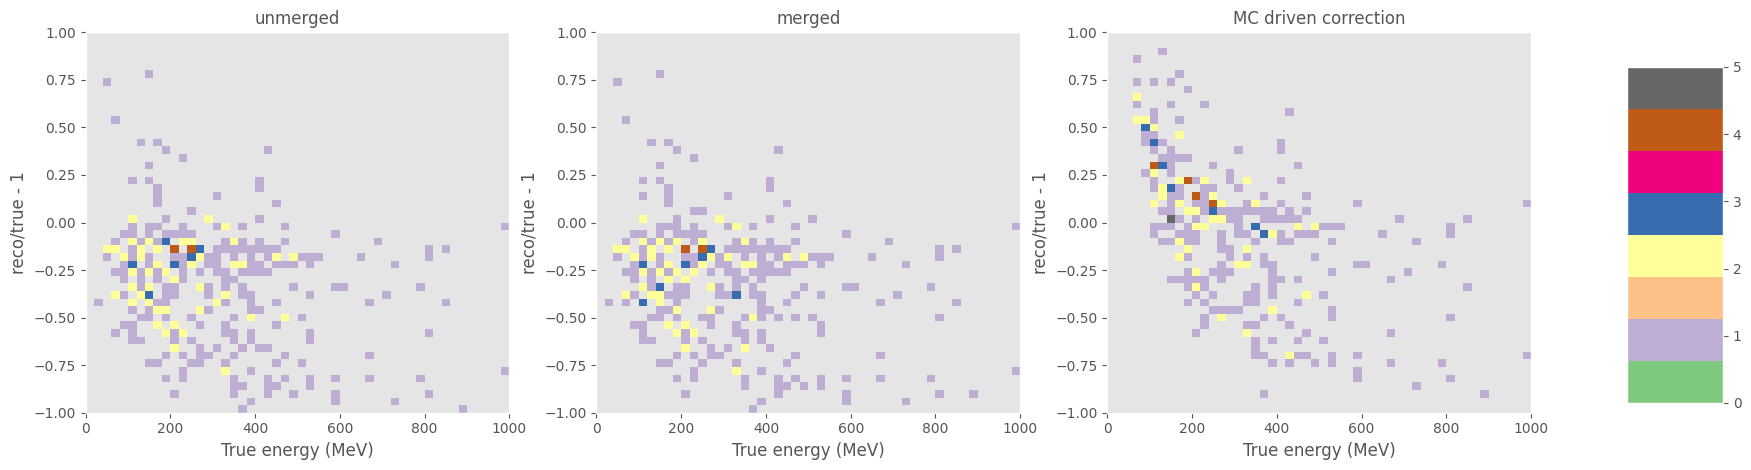

In [14]:
def FractionalEnergyPlot(reco_energy, title):
    Plots.PlotHist2D(energy["true"], (reco_energy / energy["true"]) - 1, bins = 50, y_range=(-1, 1), x_range = (0, 1200), xlabel = "True energy (MeV)", ylabel = "reco/true - 1", title = title)
    if save: Plots.Save("fractional_energy_" + title)


# [FractionalEnergyPlot(energy[e], e) for e in ["unmerged", "merged", "corrected_merged"]]
# FractionalEnergyPlot(1000 * EnergyCorrection(energy["unmerged"]/1000), "MC driven correction")

x = [energy["true"]] * 3
# y = [energy[e] for e in ["unmerged", "merged", "corrected_merged"]] + [EnergyCorrection(energy["unmerged"])]
y = [energy[e] for e in ["unmerged", "merged"]] + [EnergyCorrection(energy["unmerged"])]

y = [(e / energy["true"]) - 1 for e in y]

x_l = ["True energy (MeV)"] * 3
y_l = ["reco/true - 1"] * 3
# titles = ["unmerged", "merged", "corrected_merged", "MC driven correction"]
titles = ["unmerged", "merged", "MC driven correction"]
Hist2DComparison(x, y, (0, 1000), (-1, 1), x_l, y_l, titles, bins = 50, cmap = "Accent")
if save: Plots.Save("error_vs_true")

unmerged
merged


/tmp/ipykernel_75305/287259863.py:63: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tables.to_latex())


\begin{tabular}{lrrrr}
\toprule
{} &  unmerged &  merged &  MC driven correction &  corrected merged mass \\
\midrule
\$\textbackslash geq 1\textbackslash pi\textasciicircum \{0\} + X\$        &        21 &      21 &                    14 &                     19 \\
\$1\textbackslash pi\textasciicircum \{0\} + 0\textbackslash pi\textasciicircum \{+\}\$      &        75 &      77 &                    74 &                     72 \\
\$0\textbackslash pi\textasciicircum \{0\} + 0\textbackslash pi\textasciicircum \{+\}\$      &         2 &       3 &                     2 &                      3 \\
\$1\textbackslash pi\textasciicircum \{0\} + \textbackslash geq 1\textbackslash pi\textasciicircum \{+\}\$ &        28 &      27 &                    17 &                     23 \\
\$0\textbackslash pi\textasciicircum \{0\} + \textbackslash geq 1\textbackslash pi\textasciicircum \{+\}\$ &        14 &      13 &                    13 &                     14 \\
all                        &       14

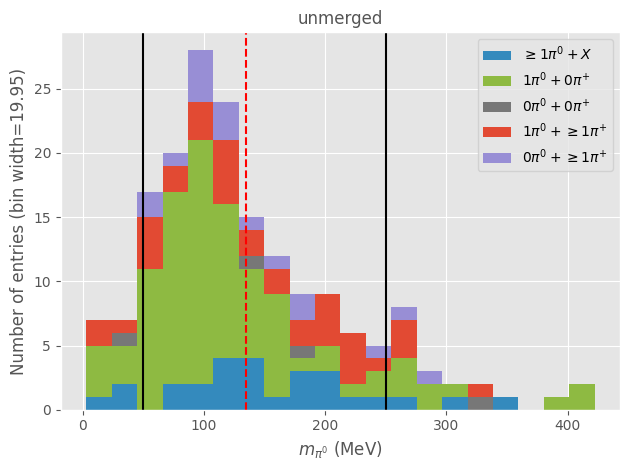

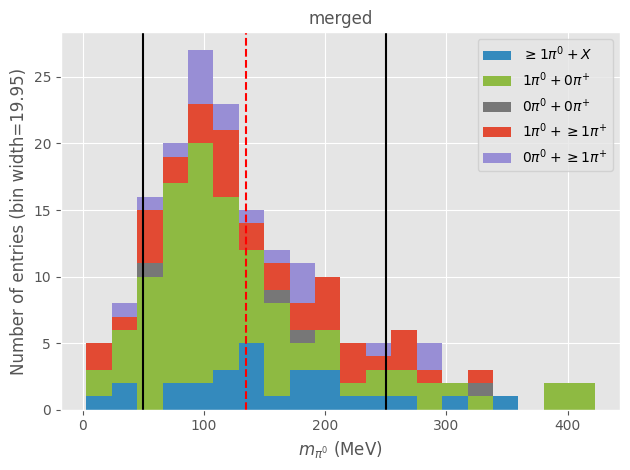

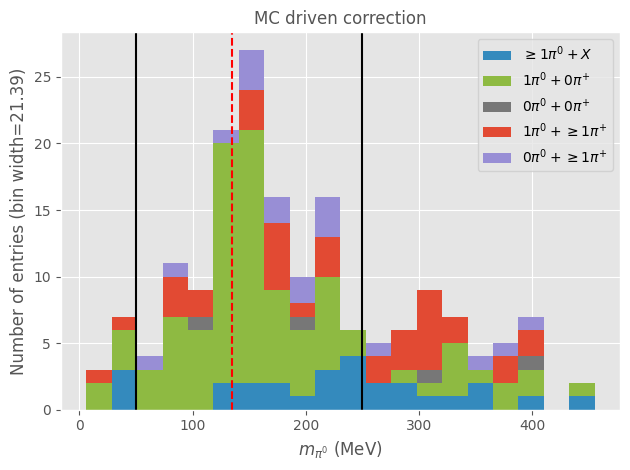

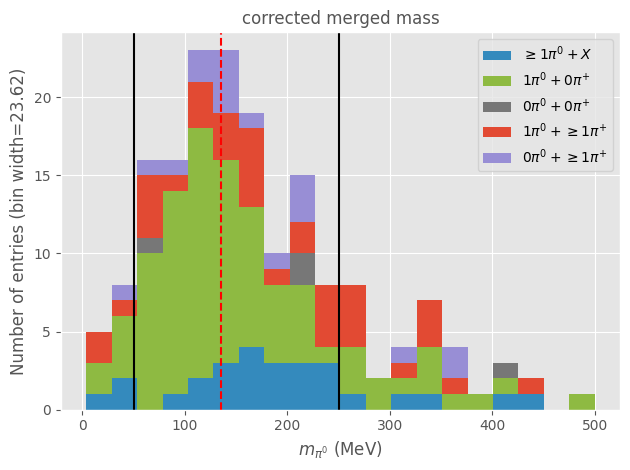

In [15]:
def PlotMass(mass, tags, title):
    Plots.PlotHist(mass, stacked = True, color = tags.colour.values, label = tags.name.values, bins = 20, title  = title, xlabel = "$m_{\pi^{0}}$ (MeV)")
    plt.axvline(134.98, c = "red", linestyle = "--")
    plt.axvline(50 , c = "black")
    plt.axvline(250, c = "black")
    if save: Plots.Save("tagged_mass_" + title)

def CountMassCut(mass):
    return ak.sum((mass > 50) & (mass < 250))

tag_map = pd.read_hdf(file, "tag_map")
metadata = pd.read_hdf(file, "metadata")

tags = shower_merging.GenerateTruthTags()

for m in tag_map:
    if m == "not tagged": continue # ignore event topologies we aren't interested in
    tags[m].mask = metadata.tag == tag_map[m].values[0]

tables = {}

for d in ["unmerged", "merged"]:
    mass = [ak.ravel(data[d].mass[tags[tag].mask].values) for tag in tags]
    mass = [m[m < 500] for m in mass]
    PlotMass(mass, tags, d)

    t = {}
    print(d)
    for tag, m in zip(tags, mass):
        t[tags[tag].name] = CountMassCut(m)
    t["all"] = ak.sum( (data[d].mass.values > 50) & (data[d].mass.values < 250) )
    tables[d] = t

mass = [shower_merging.Master.ShowerPairs.Mass(EnergyCorrection(data["unmerged"].lead_energy[tags[tag].mask]), EnergyCorrection(data["unmerged"].sub_energy[tags[tag].mask]), data["unmerged"].angle[tags[tag].mask]) for tag in tags]
mass = [m[m < 500] for m in mass]

PlotMass(mass, tags, "MC driven correction")

t = {}
for tag, m in zip(tags, mass):
    t[tags[tag].name] = CountMassCut(m)

t["all"] = CountMassCut(shower_merging.Master.ShowerPairs.Mass(EnergyCorrection(data["unmerged"].lead_energy), EnergyCorrection(data["unmerged"].sub_energy), data["unmerged"].angle))

tables["MC driven correction"] = t

corrected_merged_mass = shower_merging.Master.ShowerPairs.Mass(MergedEnergyCorrection(data["merged"].lead_energy), MergedEnergyCorrection(data["merged"].sub_energy), data["merged"].angle)
mass = [corrected_merged_mass[tags[tag].mask] for tag in tags]
mass = [m[m < 500] for m in mass]
PlotMass(mass, tags, "corrected merged mass")


t = {}
for tag, m in zip(tags, mass):
    t[tags[tag].name] = CountMassCut(m)

t["all"] = CountMassCut(corrected_merged_mass)

tables["corrected merged mass"] = t

tables = pd.DataFrame(tables)

print(tables.to_latex())

purity = tables.loc["$1\pi^{0} + 0\pi^{+}$"]/tables.loc["all"]
print(tables)
print(purity)

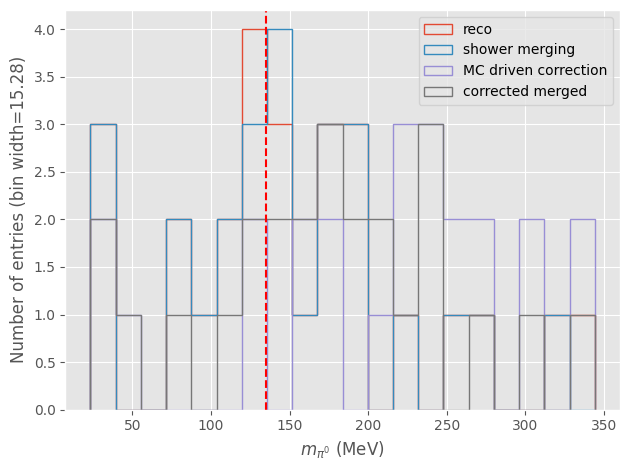

In [16]:
mask = tags.name_simple["inclusive signal"].mask

mass_signal = {
    "reco" : data["unmerged"].mass[mask].values,
    "shower merging" : data["merged"].mass[mask].values,
    "MC driven correction" : shower_merging.Master.ShowerPairs.Mass(EnergyCorrection(data["unmerged"].lead_energy[mask]), EnergyCorrection(data["unmerged"].sub_energy[mask]), data["unmerged"].angle[mask]),
    "corrected merged" : corrected_merged_mass[mask]
}

Plots.PlotHistComparison(list(mass_signal.values()), labels = list(mass_signal.keys()), bins = 20, xlabel = "$m_{\pi^{0}}$ (MeV)", density = False)
plt.axvline(134.98, c = "red", linestyle = "--")


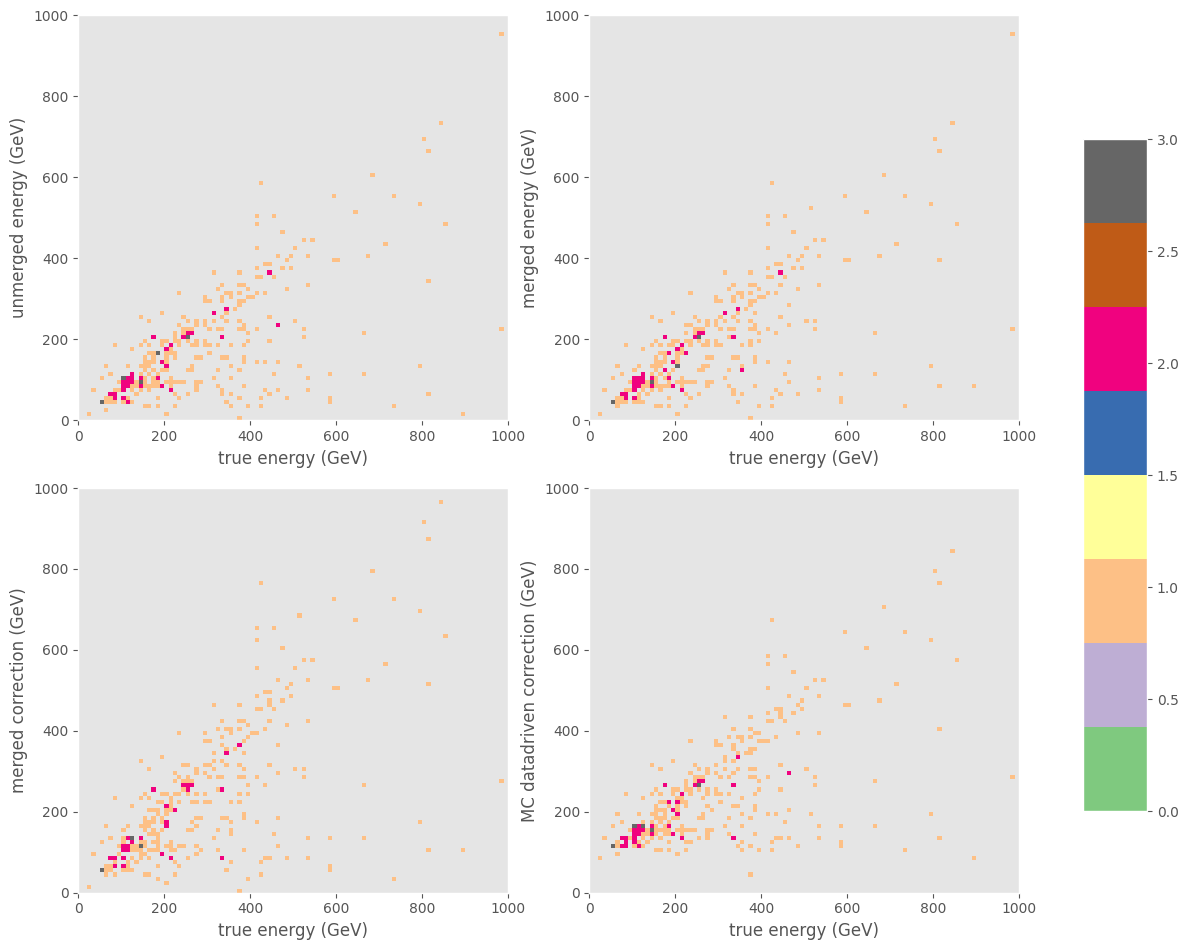

In [19]:
x = [energy["true"]] * 4
y = [energy["unmerged"], energy["merged"], MergedEnergyCorrection(energy["merged"]), EnergyCorrection(energy["unmerged"])]
x_label = ["true energy (GeV)"] * 4
y_label = ["unmerged energy (GeV)", "merged energy (GeV)", "merged correction (GeV)", "MC datadriven correction (GeV)"]

Hist2DComparison(x, y, (0, 1000), (0, 1000), x_label, y_label, bins = 100, cmap = "Accent")

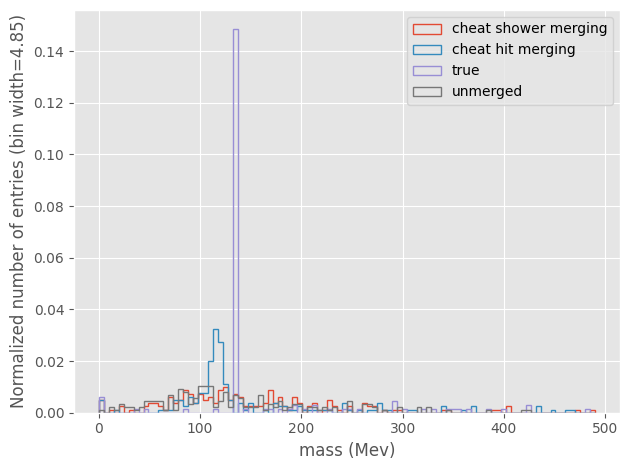

In [42]:
merged_cheat = pd.read_hdf(file, "merged_cheat/reco")
cheat = pd.read_hdf(file, "cheat/")

Plots.PlotHistComparison([merged_cheat.mass, cheat.mass, data["true"].mass, data["unmerged"].mass], xRange = [0, 500], labels = ["cheat shower merging", "cheat hit merging", "true", "unmerged"], xlabel = "mass (Mev)")


 - true sample are shower pair quantities calculated using backtracked MC particles - the reason the true mass has a spread is because the selection used was based on reconstructed information, so some false shower pairs have been selected.
 - cheat shower merging are shower pair quantities calculated using reconstructed PFO quantities but cheating the shower merging i.e. all fragmented PFOs are merged
 - cheat hit merging are shower pair quantities calculated using reconstruted hits but using truth information to merge the hits a true particle would produced in simulation. Note that this merge method only corrects the energy, so the direction used to calculate the mass in the above plot is the true direction.
 - unmerged sample are shower pair quantities calculated using reconstruced PFO quantities.

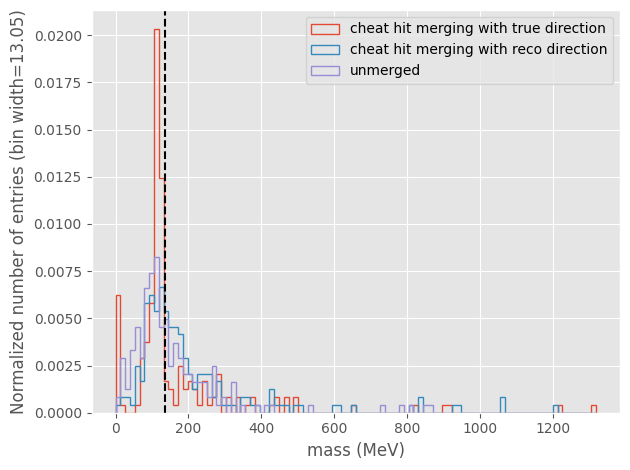

In [41]:
cheat_hit_mass_reco_direction = shower_merging.Master.ShowerPairs.Mass(cheat.lead_energy, cheat.sub_energy, data["unmerged"].angle)

Plots.PlotHistComparison([cheat.mass, cheat_hit_mass_reco_direction, data["unmerged"].mass], labels = ["cheat hit merging with true direction", "cheat hit merging with reco direction", "unmerged"], xlabel = "mass (MeV)")
plt.axvline(x = 134.98, color = "black", linestyle = "--")

When switching the true direction for the reco direction the invariant mass distribution is considerably wider. Note that when using the true direction there is a spike at zero, this occurs because the selection has selected two PFOs which backtrack to the same true photon, so the opening angle (hence mass) is zero.

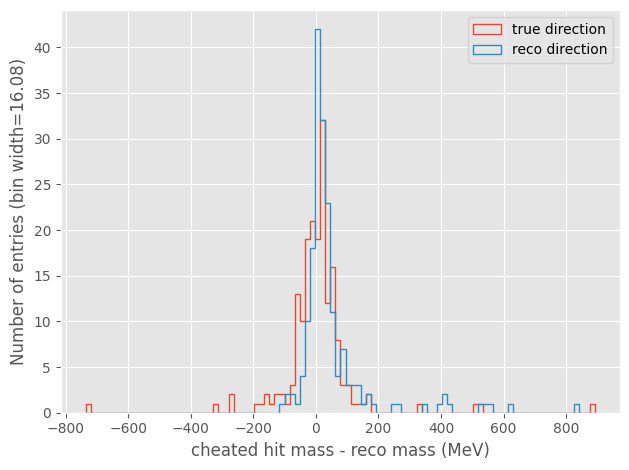

In [53]:
Plots.PlotHistComparison(
    [cheat.mass - data["unmerged"].mass, cheat_hit_mass_reco_direction - data["unmerged"].mass],
    labels = ["true direction", "reco direction"],
    xlabel = "cheated hit mass - reco mass (MeV)",
    xRange = [-1000, 1000],
    density = False)

Cheated hit mass - reco mass shows that using the reco direction with the cheated hit energy tends the invariant mass towards the reconstructed value as expected.

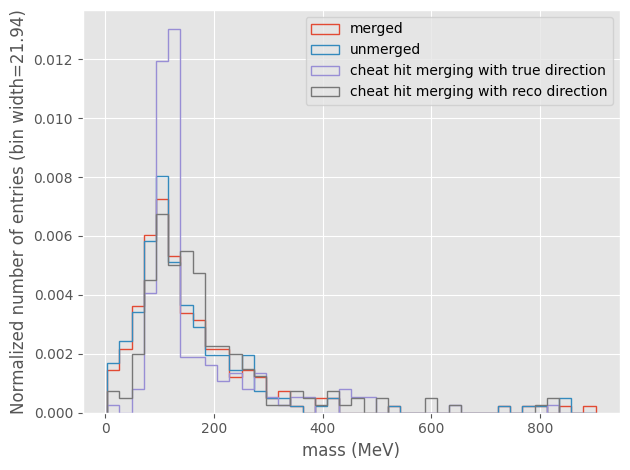

In [54]:
Plots.PlotHistComparison(
    [data["merged"].mass, data["unmerged"].mass, cheat.mass, cheat_hit_mass_reco_direction],
    labels = ["merged", "unmerged", "cheat hit merging with true direction", "cheat hit merging with reco direction"],
    xlabel = "mass (MeV)",
    bins = 40)

Likewise the merged data set is similar to the unmerged dat set if using the purity or balanced cut.

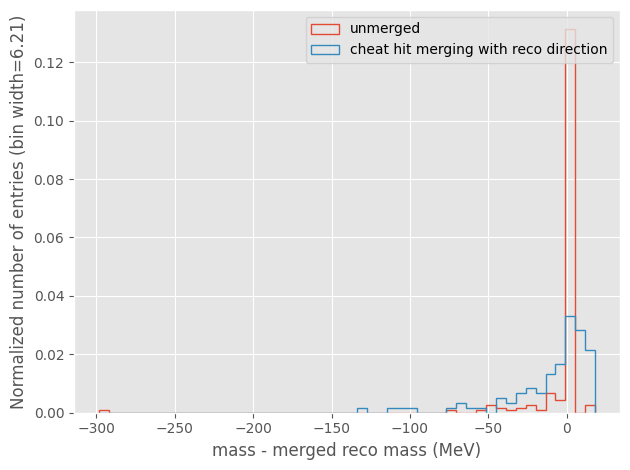

In [52]:
Plots.PlotHistComparison(
    [data["unmerged"].mass - data["merged"].mass, cheat_hit_mass_reco_direction - data["merged"].mass],
    labels = ["unmerged", "cheat hit merging with reco direction"],
    xlabel = "mass - merged reco mass (MeV)",
    bins = 50)

And when comparing the merged mass to the unmerged and cheated mass (reco direction only), the merged mass has better agreement with the unmerged mass which is expected as the efficiency of the shower merging was lower in favour of higher purity.

In [43]:
keys = [
    "unmerged/reco",
    "unmerged/error",
    "merged_cheat/reco",
    "merged_cheat/error"
]

pip_veto_file = "work/2023/Prod4a_1GeV_BeamSim_merging_analysis_v5/shower_merging/shower_pairs.hdf5"
no_veto_file  = "work/2023/Prod4a_1GeV_BeamSim_merging_analysis/shower_merging/new_tables/shower_pairs.hdf5"

save = True
out = "work/2023/Prod4a_1GeV_BeamSim_merging_analysis_v5/cheated_merging_plots/"

data_pip_veto = {k : pd.read_hdf(pip_veto_file, k) for k in keys}
data_no_veto =  {k : pd.read_hdf(no_veto_file, k) for k in keys}

tag_map = pd.read_hdf(pip_veto_file, "tag_map")

data_pip_veto["metadata"] = pd.read_hdf(pip_veto_file, "metadata")
data_no_veto["metadata"] = pd.read_hdf(no_veto_file, "metadata")


for d in [data_pip_veto, data_no_veto]:
    tags = shower_merging.GenerateTruthTags()
    cex = tags.name_simple["exclusive signal"]
    cex.mask = d["metadata"].tag == tag_map[cex.name].values[0]
    d["tag"] = cex

for k in keys:
    for d in [data_pip_veto, data_no_veto]:
        d[k] = d[k][d["tag"].mask]


In [44]:
quantities_to_plot = {
    "lead_energy"       : {"xlabel" : "Leading shower energy (MeV)"    , "range" : [0, 1000]},
    "sub_energy"        : {"xlabel" : "Sub leading shower energy (MeV)", "range" : [0, 1000]},
    "angle"             : {"xlabel" : "Opening angle (rad)"            , "range" : None},
    "mass"              : {"xlabel" : "Invariant mass (MeV)"           , "range" : [0, 500]},
    "pi0_mom_mag"       : {"xlabel" : "$\pi^{0}$ momentum (MeV)"       , "range" : [0, 1000]},
    "lead_completeness" : {"xlabel" : "Leading shower completeness"    , "range" : None },
    "lead_purity"       : {"xlabel" : "Leading shower purity"          , "range" : None },
    "sub_completeness"  : {"xlabel" : "Sub leading shower completeness", "range" : None },
    "sub_purity"        : {"xlabel" : "Sub leading shower purity"      , "range" : None }
}

selection_labels = ["no daughter $\pi^{+}$ veto", "daughter $\pi^{+}$ veto applied"]
merging_labels = ["original", "cheated merging"]


for q, s in quantities_to_plot.items():
    Plots.PlotHistComparison([data_no_veto["unmerged/reco"][q], data_pip_veto["unmerged/reco"][q]]  , labels = selection_labels, bins = 30, xlabel = s["xlabel"], xRange = s["range"], title = "reco")
    if save : Plots.Save(f"reco_selection_{q}", out, 300)

    if q not in ["lead_completeness", "lead_purity", "sub_completeness", "sub_purity"]:
        Plots.PlotHistComparison([data_no_veto["unmerged/error"][q], data_pip_veto["unmerged/error"][q]], labels = selection_labels, bins = 30, xlabel = s["xlabel"], xRange = [-1, 1], title = "fractional error")
        if save : Plots.Save(f"error_selection_{q}", out, 300)

    Plots.PlotHistComparison([data_pip_veto["unmerged/reco"][q], data_pip_veto["merged_cheat/reco"][q]]  , labels = merging_labels, bins = 30, xlabel = s["xlabel"], xRange = s["range"], title = "reco")
    if save : Plots.Save(f"reco_merge_{q}", out, 300)

    if q not in ["lead_completeness", "lead_purity", "sub_completeness", "sub_purity"]:
        Plots.PlotHistComparison([data_pip_veto["unmerged/error"][q], data_pip_veto["merged_cheat/error"][q]], labels = merging_labels, bins = 30, xlabel = s["xlabel"], xRange = [-1, 1], title = "fractional error")
        if save : Plots.Save(f"error_merge_{q}", out, 300)
